In [1]:
%matplotlib inline
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
import pydicom
import matplotlib.pyplot as plt
import os.path

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

In [3]:
def CropIt(dicom_array):
    img = np.uint16(dicom_array)
    #img = np.stack((img,)*3, axis=-1)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((5,4), np.uint8) 
    gray = cv2.erode(img, kernel, iterations=3)
    gray = cv2.dilate(gray, kernel, iterations=3)
    
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(gray,-1,kernel)
    Z = dst.reshape((-1))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    km = res.reshape((dst.shape))
    #ShowImage('km brain',km,'gzray')
    
    ret, thresh = cv2.threshold(km,0,100,cv2.THRESH_OTSU)
    #ShowImage('thresh brain',thresh,'gray')
    """
    colormask = np.zeros(img.shape, dtype=np.uint8)
    colormask[thresh!=0] = np.array((200,150,50))
    blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
    """
    ret, markers = cv2.connectedComponents(thresh)
    
    
    #Get the area taken by each component. Ignore label 0 since this is the background.
    if ret!=2:
        marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
    else:
        marker_area = [np.sum(markers==m) for m in range(np.max(markers))] 
    
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
    
    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component
    
    brain_out = img.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    brain_out[brain_mask==False] = 0
    
    return(brain_out)

In [4]:
def CropTumor(dicom_array):
    img = np.uint16(dicom_array)
    #img = np.stack((img,)*3, axis=-1)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((4,3), np.uint16) 
    gray = cv2.erode(img, kernel, iterations=2)
    gray = cv2.dilate(gray, kernel, iterations=2)
    
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(gray,-1,kernel)
    Z = gray.reshape((-1))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 5
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint16(center)
    res = center[label.flatten()]
    km = res.reshape((dst.shape))
    
    maxVal = np.max(km)
    print('Maximum pixel Value present (Used to determine the presence of tumor in brain) : ',maxVal)
    
    count = np.count_nonzero(km == maxVal)
    #print(count)
    
    percent = count/(km.shape[0]*km.shape[1])
    print('Percentage of maxPixel present : ',percent)
    
    #ShowImage('km brain',km,'gray')
    
    if percent>0.05 or percent<0.001 or maxVal<130:
        trial = np.zeros((img.shape))
        
        return(trial)
    else:
        trial = img.copy()
        trial = np.uint8(trial)
        #In a copy of the original image, clear those pixels that don't correspond to the brain
        #trial[km<maxVal] = 0
        
        for i in range(km.shape[0]):
            for j in range(km.shape[1]):
                if(km[i][j]==maxVal):
                    trial[i][j]=km[i][j]
                else:
                    trial[i][j]=0
        
        #print(np.max(trial))
        ret, thresh = cv2.threshold(trial,0,1024,cv2.THRESH_OTSU)
        
        #ShowImage('thresh',thresh,'gray')
        
        ret, markers = cv2.connectedComponents(thresh)
        
        #Get the area taken by each component. Ignore label 0 since this is the background.
        if ret!=2:
            marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
        else:
            marker_area = [np.sum(markers==m) for m in range(np.max(markers))] 

        #Get label of largest component by area
        largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        

        #Get pixels which correspond to the brain
        trial_mask = markers==largest_component

        trial_out = img.copy()
        #In a copy of the original image, clear those pixels that don't correspond to the brain
        trial_out[trial_mask==False] = 0
        
        return(trial_out)

In [5]:
def CropTumorless(brain,tumor):
    tumorless=np.zeros((brain.shape))
    #tumorless[tumor!=0]=0
    #tumorless[tumor==0]=brain
    
    for i in range(brain.shape[0]):
        for j in range(brain.shape[1]):
            if(tumor[i][j]==0):
                tumorless[i][j]=brain[i][j]
            else:
                tumorless[i][j]=0
    
    return(tumorless)

In [6]:
InputPath = 'original'
TumorPath = 'tumor'
TumorlessPath = 'tumorless'
num_files = len([f for f in os.listdir(InputPath)
                if os.path.isfile(os.path.join(InputPath, f))])
print(num_files)
start = int(num_files*0.43)
end = int(num_files*0.87)
print(start,end)

112
48 97


In [7]:
if start<10 and end<10:
    flag=1
elif start<10 and end>10 and end<100:
    flag=2
elif start>10 and end<100:
    flag=3
else:
    flag=4
print(flag)

3


48
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  94
Percentage of maxPixel present :  0.100555419921875


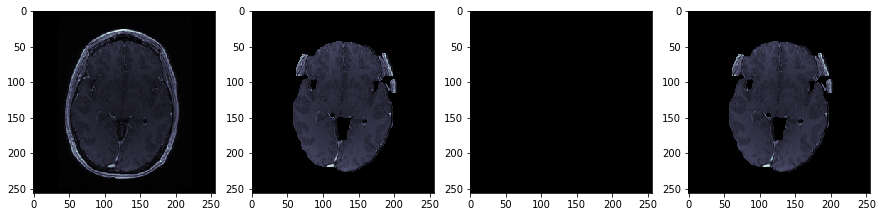

49
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  96
Percentage of maxPixel present :  0.0937347412109375


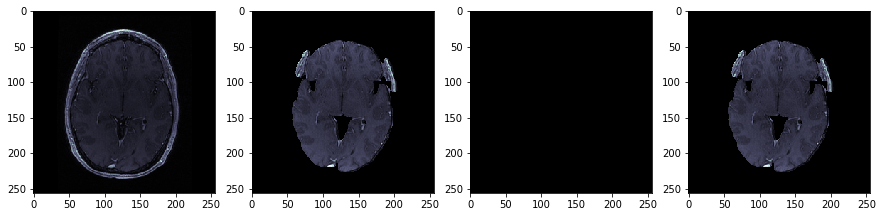

50
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  97
Percentage of maxPixel present :  0.08624267578125


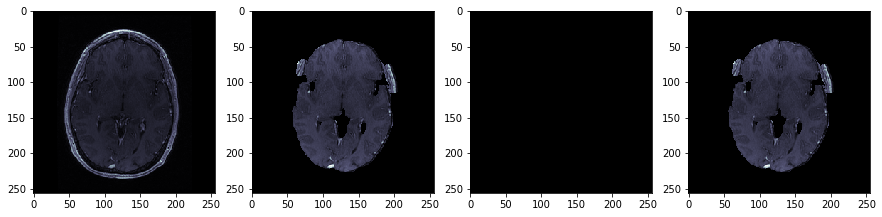

51
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  105
Percentage of maxPixel present :  0.04754638671875


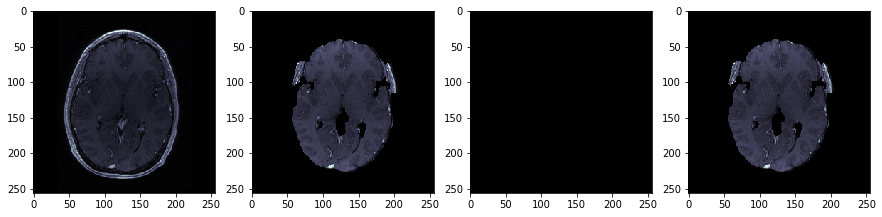

52
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  102
Percentage of maxPixel present :  0.0779876708984375


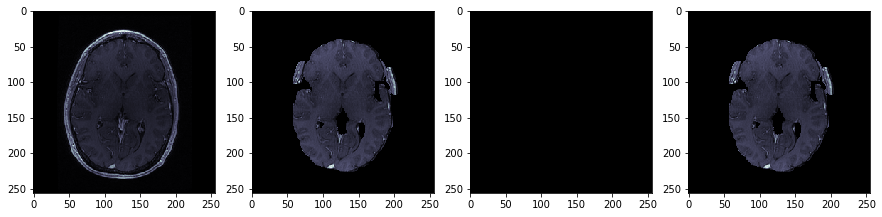

53
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  99
Percentage of maxPixel present :  0.085357666015625


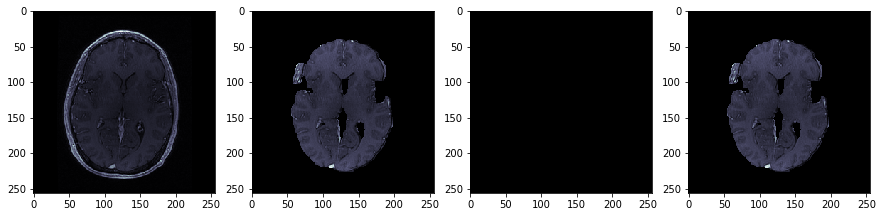

54
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  103
Percentage of maxPixel present :  0.0604248046875


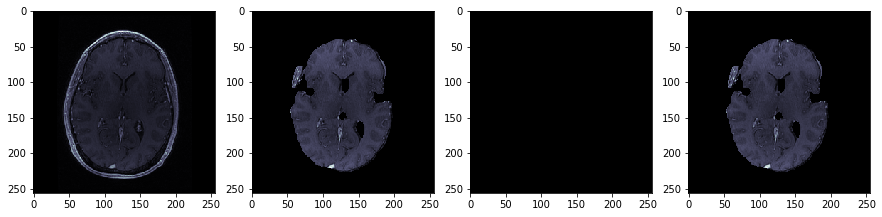

55
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  100
Percentage of maxPixel present :  0.0800018310546875


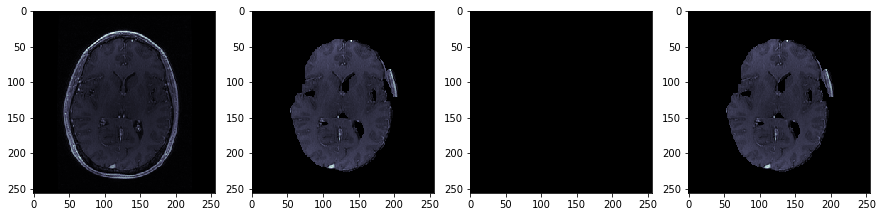

56
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  100
Percentage of maxPixel present :  0.081207275390625


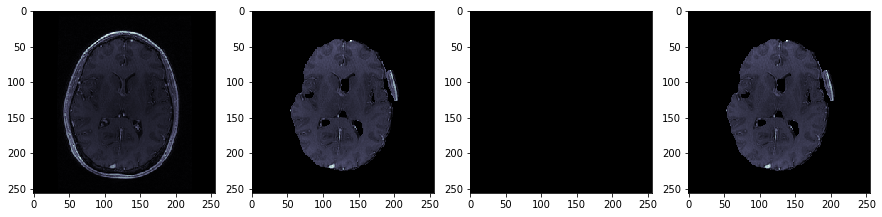

57
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  103
Percentage of maxPixel present :  0.04901123046875


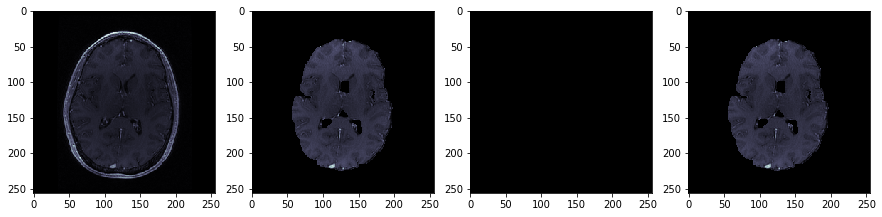

58
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  99
Percentage of maxPixel present :  0.07794189453125


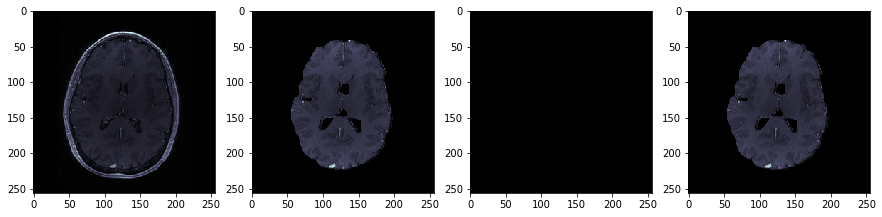

59
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  100
Percentage of maxPixel present :  0.0742340087890625


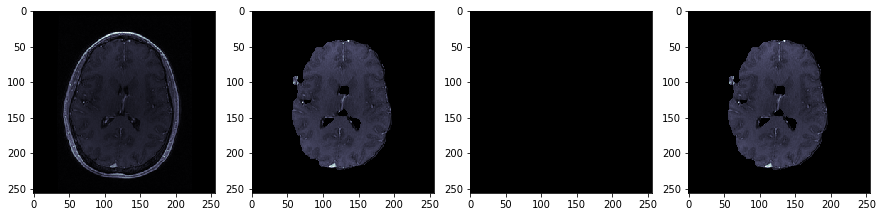

60
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  99
Percentage of maxPixel present :  0.074432373046875


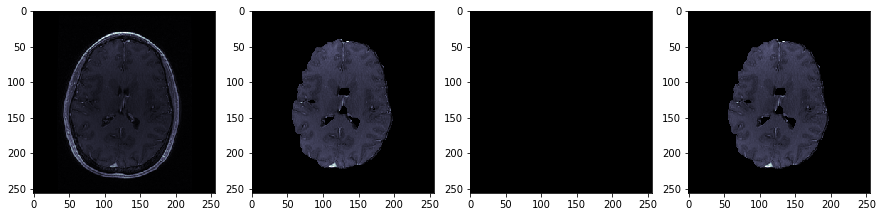

61
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  99
Percentage of maxPixel present :  0.062286376953125


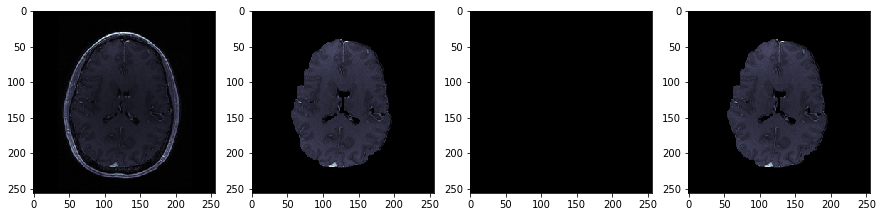

62
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  96
Percentage of maxPixel present :  0.084564208984375


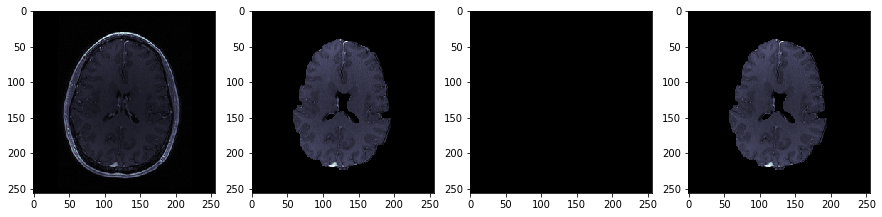

63
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  97
Percentage of maxPixel present :  0.068511962890625


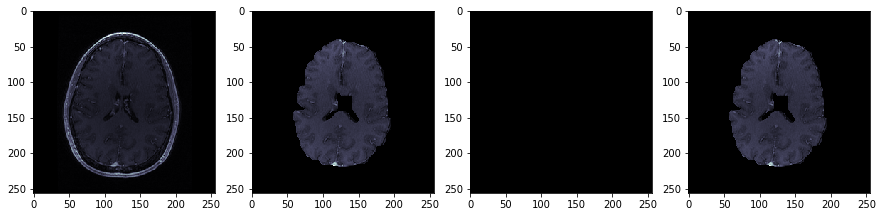

64
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  97
Percentage of maxPixel present :  0.0743865966796875


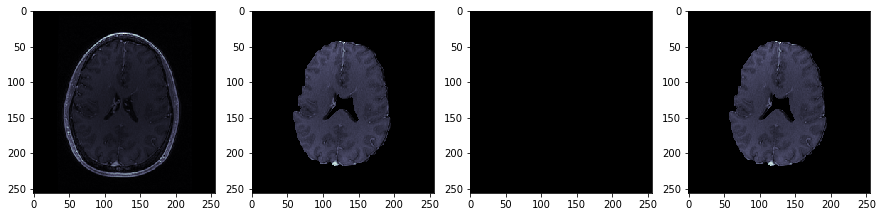

65
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  101
Percentage of maxPixel present :  0.0452117919921875


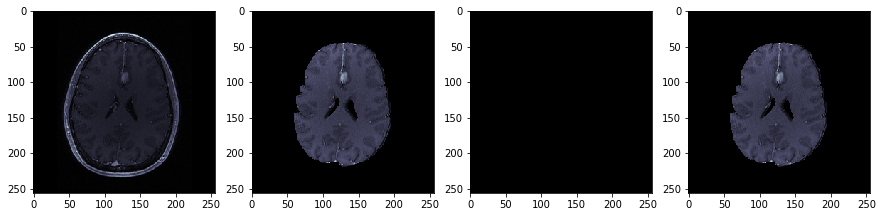

66
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  157
Percentage of maxPixel present :  0.003387451171875


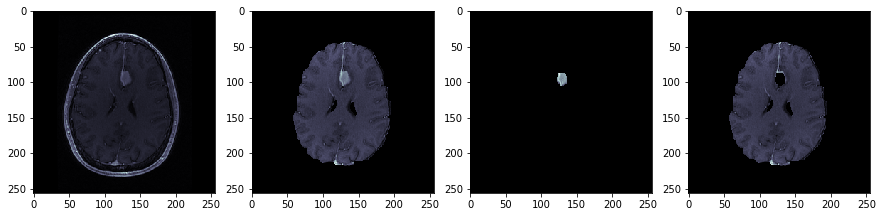

67
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  154
Percentage of maxPixel present :  0.0050811767578125


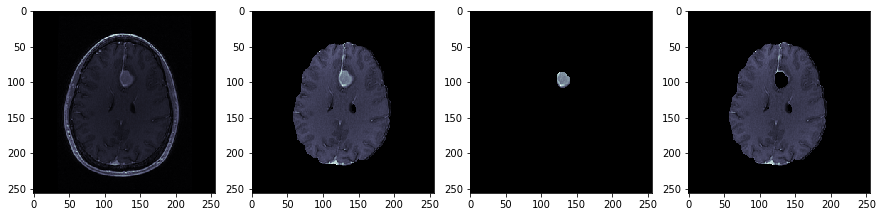

68
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  157
Percentage of maxPixel present :  0.0068206787109375


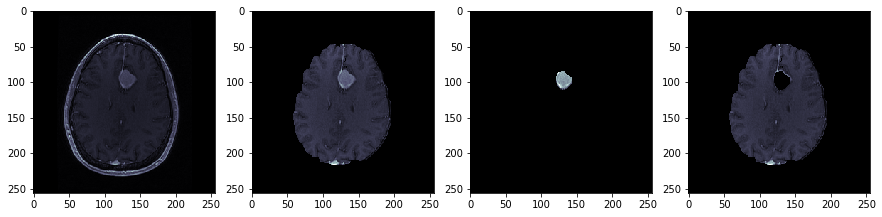

69
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  154
Percentage of maxPixel present :  0.0084075927734375


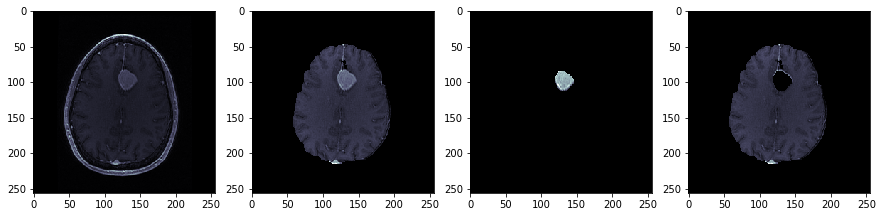

70
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  157
Percentage of maxPixel present :  0.0096282958984375


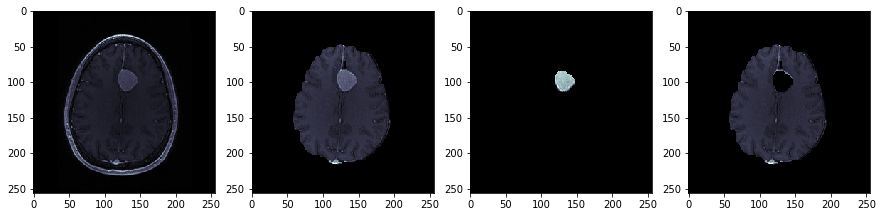

71
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  161
Percentage of maxPixel present :  0.010467529296875


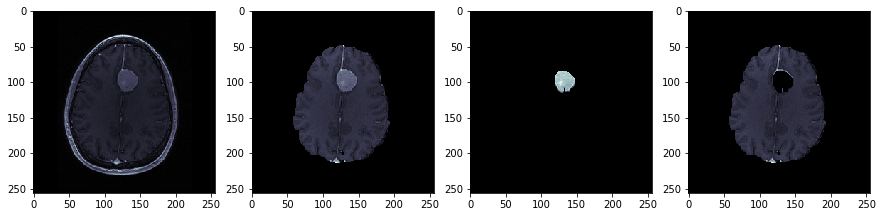

72
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  163
Percentage of maxPixel present :  0.0113372802734375


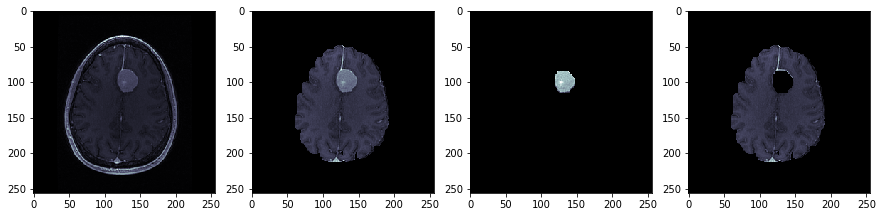

73
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  161
Percentage of maxPixel present :  0.01177978515625


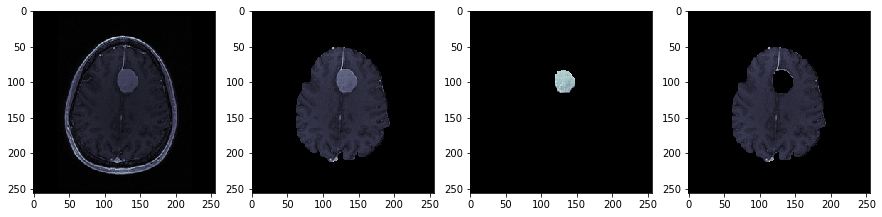

74
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  162
Percentage of maxPixel present :  0.0121917724609375


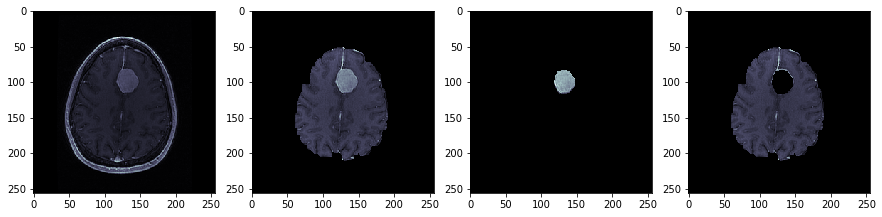

75
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  161
Percentage of maxPixel present :  0.0122222900390625


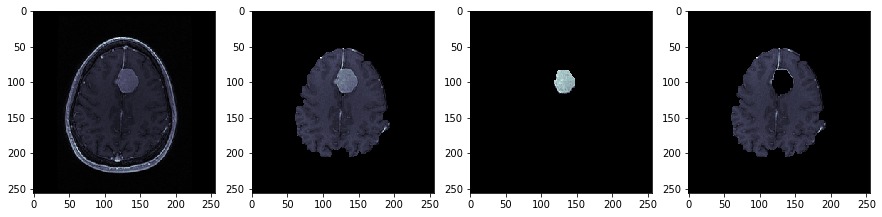

76
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  161
Percentage of maxPixel present :  0.012664794921875


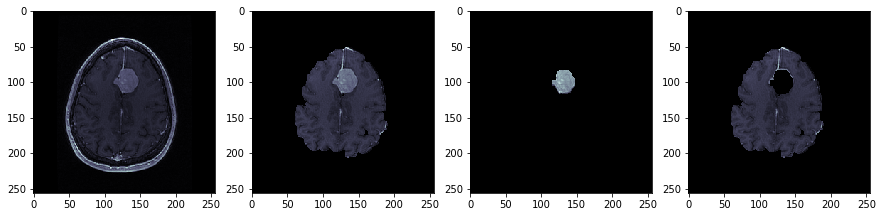

77
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  164
Percentage of maxPixel present :  0.01263427734375


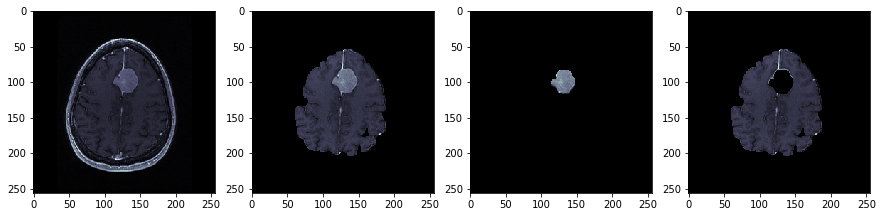

78
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  165
Percentage of maxPixel present :  0.012420654296875


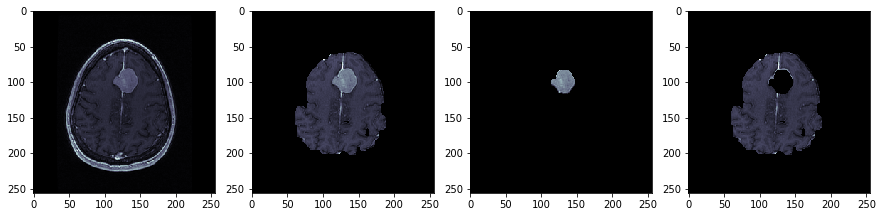

79
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  163
Percentage of maxPixel present :  0.012176513671875


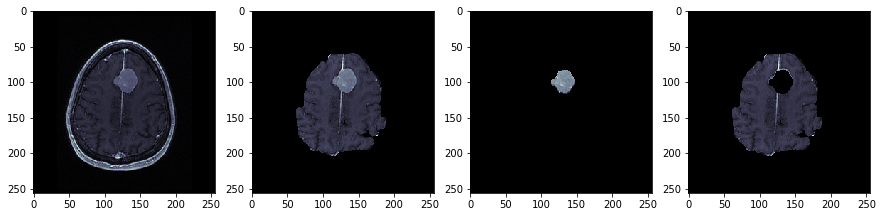

80
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  163
Percentage of maxPixel present :  0.0111846923828125


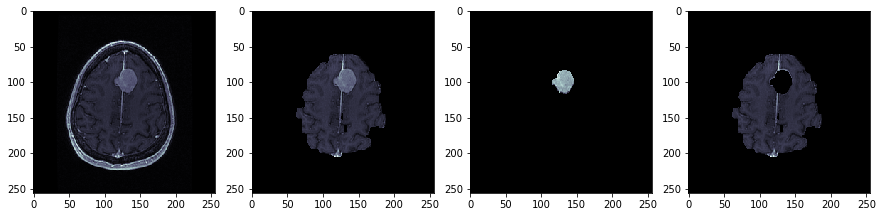

81
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  163
Percentage of maxPixel present :  0.0098876953125


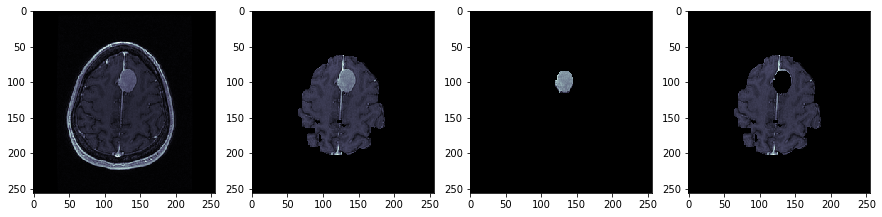

82
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  159
Percentage of maxPixel present :  0.0092010498046875


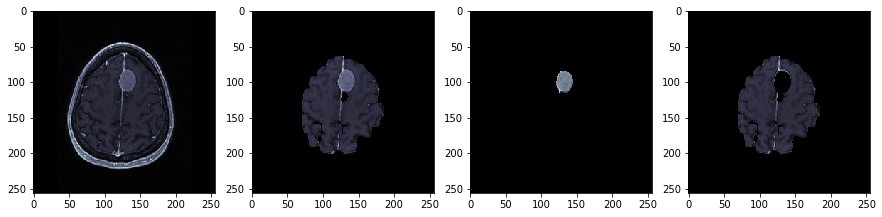

83
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  157
Percentage of maxPixel present :  0.00836181640625


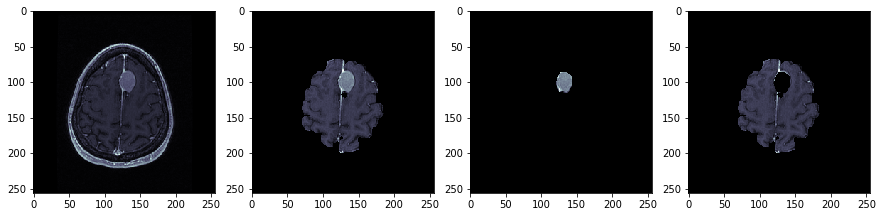

84
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  159
Percentage of maxPixel present :  0.0073699951171875


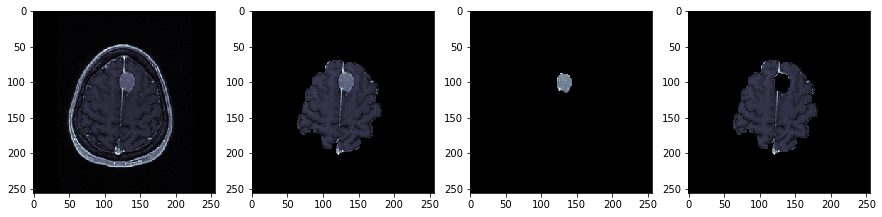

85
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  157
Percentage of maxPixel present :  0.0064544677734375


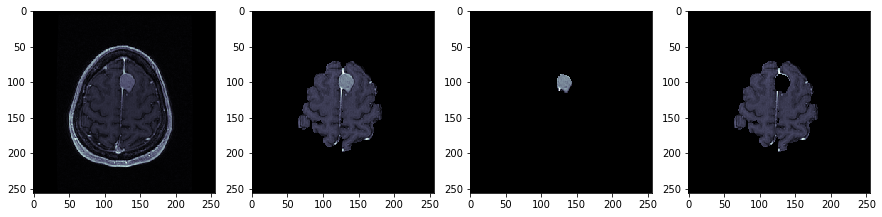

86
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  158
Percentage of maxPixel present :  0.0051116943359375


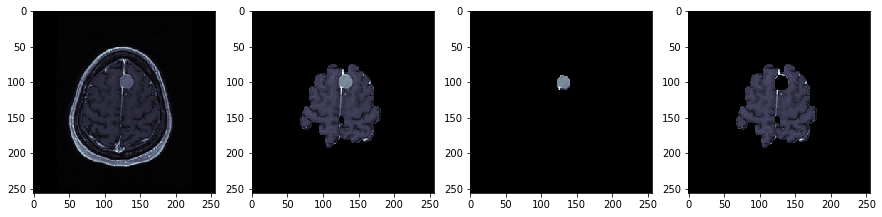

87
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  154
Percentage of maxPixel present :  0.003753662109375


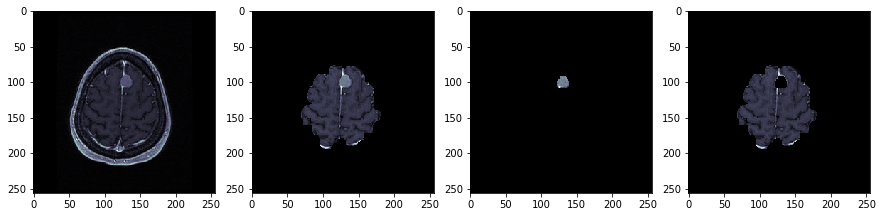

88
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  151
Percentage of maxPixel present :  0.0026397705078125


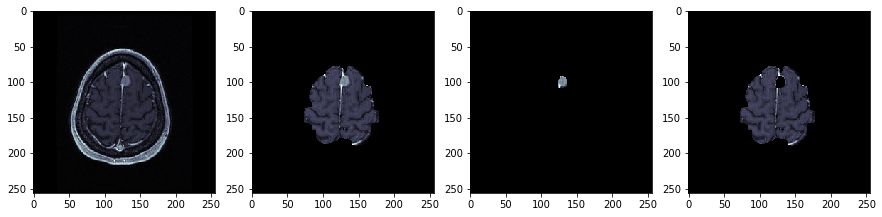

89
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  149
Percentage of maxPixel present :  0.001953125


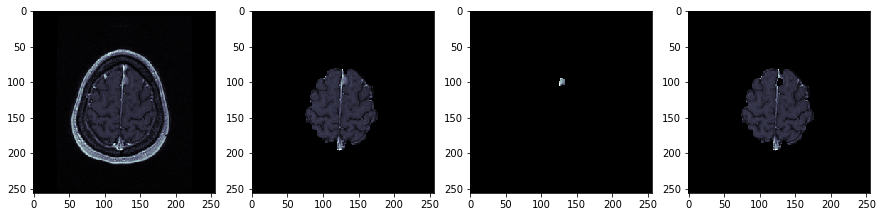

90
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  79
Percentage of maxPixel present :  0.0372314453125


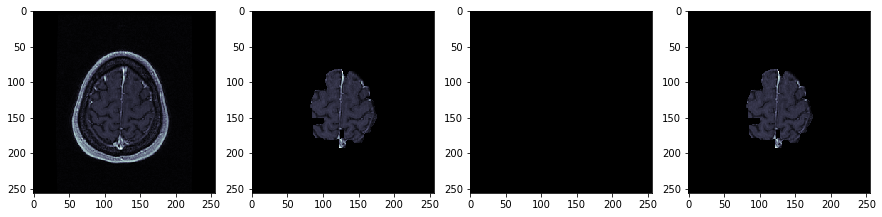

91
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  78
Percentage of maxPixel present :  0.041259765625


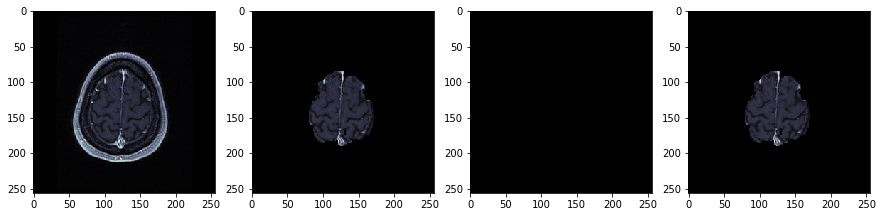

92
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  144
Percentage of maxPixel present :  0.002288818359375


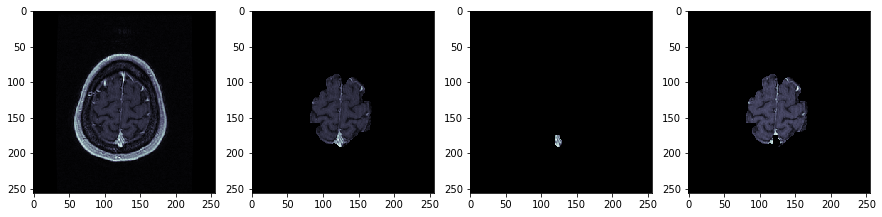

93
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  112
Percentage of maxPixel present :  0.0027008056640625


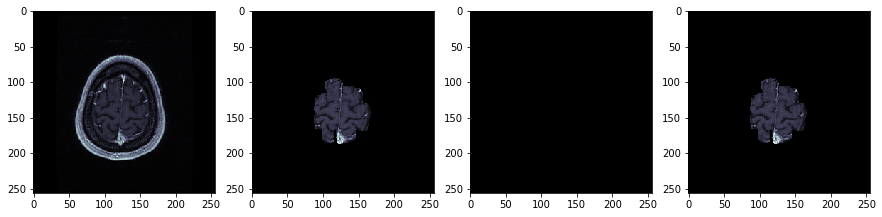

94
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  162
Percentage of maxPixel present :  0.0019378662109375


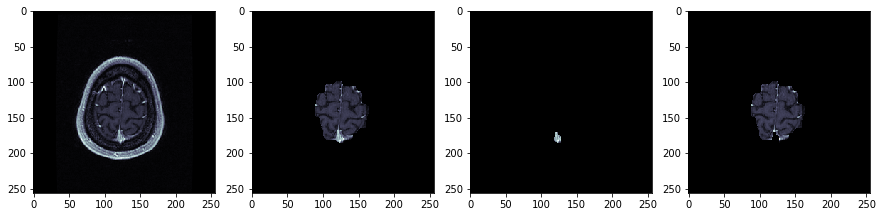

95
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  161
Percentage of maxPixel present :  0.00146484375


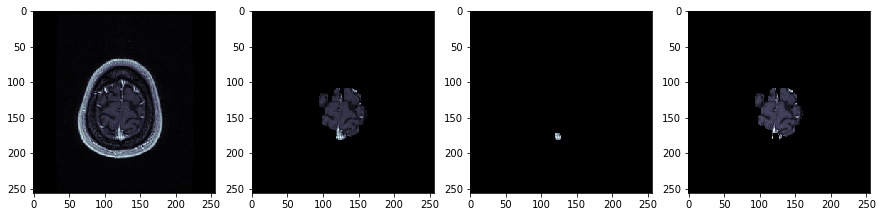

96
Maximum pixel Value present (Used to determine the presence of tumor in brain) :  145
Percentage of maxPixel present :  0.001495361328125


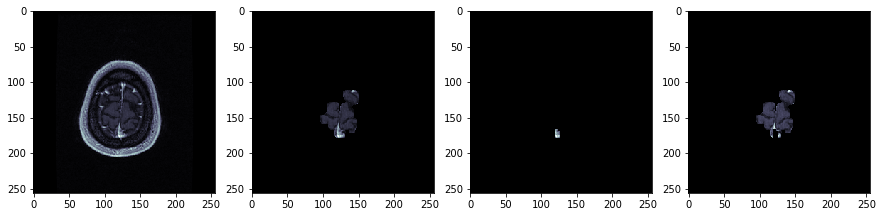

In [8]:
startTumor = 1
startTumorless = 1

if flag==1:
    for i in range(start,end):
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        #ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
elif flag==2:
    for i in range(start,9):
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        print(i)
        plt.figure(figsize=(10, 10))
        plt.subplot(1,4,1)
        plt.imshow(dicomImage, cmap=plt.cm.bone)
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        #ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        plt.subplot(1,4,2)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.subplot(1,4,3)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.subplot(1,4,4)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        #plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
        
    for i in range(10,end):
        ds = pydicom.dcmread(InputPath+'\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        print(i)
        plt.figure(figsize=(10, 10))
        plt.subplot(1,4,1)
        plt.imshow(dicomImage, cmap=plt.cm.bone)
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        #ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG00"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG00"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        plt.subplot(1,4,2)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.subplot(1,4,3)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.subplot(1,4,4)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        #plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
elif flag==3:
    for i in range(start,end):
        ds = pydicom.dcmread(InputPath+'\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        print(i)
        plt.figure(figsize=(15, 15))
        plt.subplot(1,4,1)
        plt.imshow(dicomImage, cmap=plt.cm.bone)
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        #ds.save_as("Brain\IMG000"+str(i)+".dcm")
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        
        plt.subplot(1,4,2)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.subplot(1,4,3)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.subplot(1,4,4)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        #plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
else:
    """
    for i in range(start,9):   
        ds = pydicom.dcmread(InputPath+'\IMG000'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        print(i)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
    """
    for i in range(start,99):   
        ds = pydicom.dcmread(InputPath+'\IMG00'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        print(i)
        plt.figure(figsize=(15, 15))
        plt.subplot(1,4,1)
        plt.imshow(dicomImage, cmap=plt.cm.bone)
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        plt.subplot(1,4,2)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.subplot(1,4,3)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.subplot(1,4,4)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        #plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()
        
    for i in range(100,end):   
        ds = pydicom.dcmread(InputPath+'\IMG0'+str(i)+'.dcm')
        dicomImage = ds.pixel_array
        
        print(i)
        plt.figure(figsize=(15, 15))
        plt.subplot(1,4,1)
        plt.imshow(dicomImage, cmap=plt.cm.bone)
        
        brain = np.zeros(dicomImage.shape)
        brain = CropIt(dicomImage)
        ds.pixel_array.flat=brain.flat
        ds.PixelData = ds.pixel_array.tobytes()
        
        tumor = np.zeros(dicomImage.shape)
        tumor = CropTumor(dicomImage)
        ds.pixel_array.flat=tumor.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorPath+"\IMG000"+str(startTumor)+".dcm")
        startTumor = startTumor+1
        
        tumorless = np.zeros(dicomImage.shape)
        tumorless = CropTumorless(brain,tumor)
        ds.pixel_array.flat=tumorless.flat
        ds.PixelData = ds.pixel_array.tobytes()
        ds.save_as(TumorlessPath+"\IMG000"+str(startTumorless)+".dcm")
        startTumorless = startTumorless+1
        
        plt.subplot(1,4,2)
        plt.imshow(brain, cmap=plt.cm.bone)
        plt.subplot(1,4,3)
        plt.imshow(tumor, cmap=plt.cm.bone)
        plt.subplot(1,4,4)
        plt.imshow(tumorless, cmap=plt.cm.bone)
        #plt.imshow(tumorless, cmap=plt.cm.bone)
        plt.show()